# Quickstart: Basic Usage

## Introduction 

`sensemakr` for Python (PySensemakr) implements a suite of sensitivity analysis tools that makes it easier to understand the impact of omitted variables in linear regression models, as discussed in [Cinelli, C. and Hazlett, C. (2020) “Making
Sense of Sensitivity: Extending Omitted Variable Bias.” Journal of the
Royal Statistical Society, Series B (Statistical
Methodology).](https://doi.org/10.1111/rssb.12348) The Python version of the package closely mirrors the R version, which can be found [here](https://github.com/carloscinelli/sensemakr). 

## Violence in Darfur

In this quickstart, we demonstrate the basic usage of the package by reproducing  Section 5 of Cinelli and Hazlett (2020), which estimates the effects of exposure to violence on attitudes towards peace, in Darfur. Throughout this manual, we mainly focus on the code. For detailed explanations, please refer to the original paper.

### Running a simple regression model 

In 2003 and 2004, the Darfurian government orchestrated a horrific campaign of violence against civilians, killing an estimated two hundred thousand people. In this application, we are interested in answering the following question: did being directly exposed to harm made individuals more "angry," and thus more likely to ask for revenge, or did it make them more "weary," and thus more likely to ask for peace?  

`PySensemakr` comes with the Darfur dataset, which can be loaded with the command `data.load_darfur()` of the `data` module. 

In [1]:
# Imports
from sensemakr import data

# loads data
darfur = data.load_darfur()
darfur.head()

,wouldvote,peacefactor,peace_formerenemies,peace_jjindiv,peace_jjtribes,gos_soldier_execute,directlyharmed,age,farmer_dar,herder_dar,pastvoted,hhsize_darfur,village,female
0,0,1.000000,1,1,1,0,0,30,0,0,1,23,Abdel Khair,0
1,0,0.706831,0,1,1,0,0,20,1,0,1,5,Abdi Dar,1
2,1,0.000000,0,0,0,1,0,45,1,0,0,15,Abu Sorog,0
3,1,0.495178,1,0,0,0,1,55,0,0,0,9,Abu Dejaj,0
4,0,0.000000,0,0,0,1,1,25,1,0,1,7,Abu Dejaj,1


A natural approach for such problem is to run the following linear regression model, where we regress `peacefactor` on `directlyharmed`, further adjusting for `village`, `female` as well as other covariates. Here we run this regression using `statsmodel`.

In [2]:
# runs regression model
import statsmodels.formula.api as smf
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
darfur_model = reg_model.fit()

The above regression results in the following estimate and standard errors for the coefficient of `directlyharmed`:

In [3]:
from statsmodels.iolib.summary2 import summary_col
summary_col(darfur_model, regressor_order=["directlyharmed"], drop_omitted=True)

,peacefactor
directlyharmed,0.0973
,(0.0233)
R-squared,0.5115
R-squared Adj.,0.2046


According to this model, those individual who were directly exposed to harm became on average more “pro-peace,” not less.

## Sensitivity Analysis
The causal interpretation of the previous estimate, however, relies on the assumption that `village` and `gender` are sufficient for control of confounding---in other words, it requires the assumption of *no unobserved confounders*. What if is wrong? How strong would these unobserved variables have to be in order to change the original research conclusions? The goal of `sensemakr' is precisely that, i.e, to make it easier to understand the impact that omitted variables would have on a regression result.  

The main function of the package is the function `Sensemakr` of the `sensemakr` module. The `Sensemakr` function defines an object of class `Sensemakr,`  performing the most commonly required sensitivity analyses which can then be further explored with the `summary` and `plot` methods of the object. This function is mainly a convenience wrapper for other sensitivity functions defined in the package, which can also be called directly, as we detail next. 

In the code chunk below, we first load the module `sensemakr` and then we apply the function `Sensemakr` to our OLS model from `statsmodel`.

In [4]:
# import sensemakr module
from sensemakr import sensemakr

# Create a Sensemakr object
s = sensemakr.Sensemakr(model = darfur_model, 
                        treatment = "directlyharmed", 
                        benchmark_covariates = ["female"], 
                        kd = [1,2,3],
                        ky = [1,2,3],
                        q = 1.0, 
                        alpha = 0.05, 
                        reduce = True)

The main arguments of the call are:

**model**: the OLS model with the outcome regression. In our case, `darfur_model`.


**treatment**: the name of the treatment variable. In our case, "directlyharmed".


**benchmark_covariates**: the names of covariates that will be used to bound the plausible strength of the unobserved confounders. Here, we put "female", which is arguably one of the main determinants of exposure to violence, and also a strong determinant of attitudes towards peace.


**kd** and **ky**: these arguments parameterize how many times stronger the confounder is related to the treatment (kd) and to the outcome (ky) in comparison to the observed benchmark covariates (in this case, female). In our example, setting `kd = [1, 2, 3]` and `ky = [1,2,3]` means we want to investigate the maximum strength of a confounder once, twice, or three times as strong as female (in explaining treatment and outcome variation). If only `kd` is given, `ky` will be set equal to `kd`.


**q**: fraction of the effect estimate that would have to be explained away to be problematic. Setting q = 1, means that a reduction of 100% of the current effect estimate, that is, a true effect of zero, would be deemed problematic. The default is 1.


**alpha**: significance level of interest for statistical inference. The default is 0.05.


**reduce**: should we consider confounders acting towards increasing or reducing the absolute value of the estimate? The default is `reduce = True`, which means we are considering confounders that pull the estimate towards (or through) zero.


Using the default arguments, one can simplify the previous call to:

In [9]:
# Create a Sensemakr object
s = sensemakr.Sensemakr(model = model, 
                        treatment = "directlyharmed", 
                        benchmark_covariates = ["female"], 
                        kd = [1,2,3])

Once we run `Sensemakr`, we can now explore the sensitivity analysis results.

### Minimal sensitivity reporting


AttributeError: 'Sensemakr' object has no attribute 'print'

In [5]:
s.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1.0 : 0.139
  Robustness Value, q = 1.0 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustnes

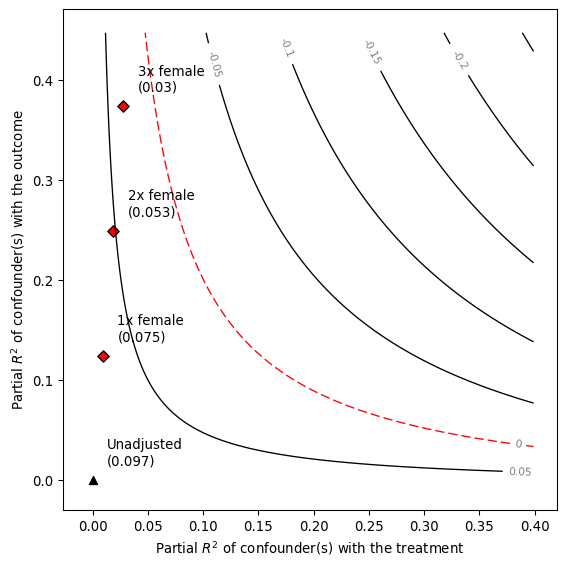

In [6]:
# Make a contour plot for the estimate
s.plot(plot_type='contour',sensitivity_of='estimate')

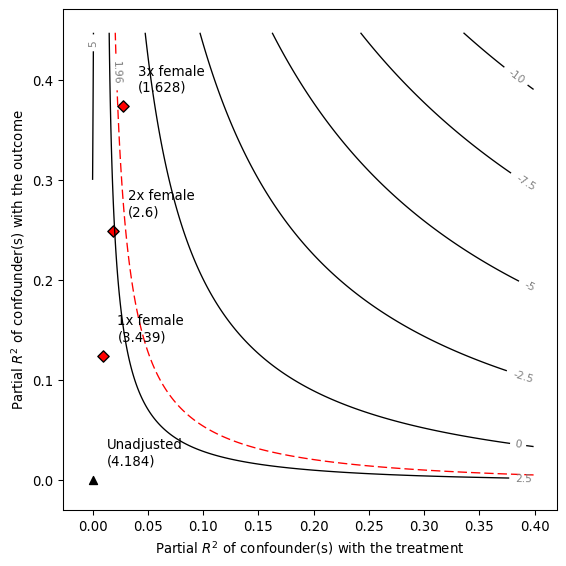

In [7]:
s.plot(plot_type='contour',sensitivity_of='t-value')

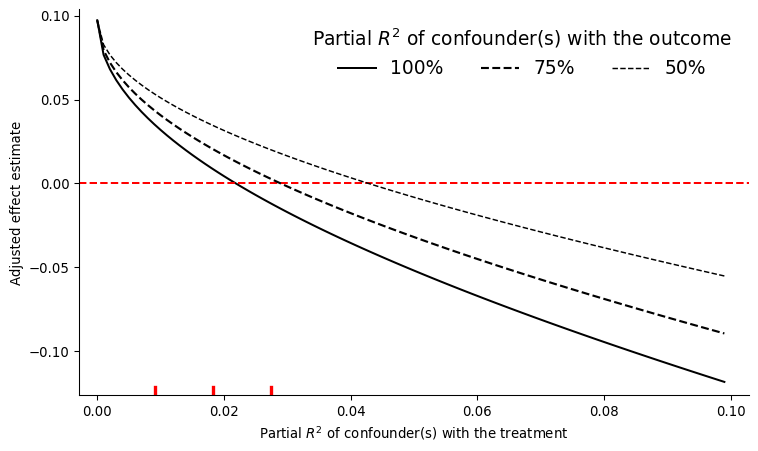

In [8]:
s.plot(plot_type='extreme',sensitivity_of='estimate')

## References
Cinelli, C. Hazlett, C. (2020) “Making Sense of Sensitivity: Extending Omitted Variable Bias”. Journal of the Royal Statistical Society, Series B (Statistical Methodology).

Hazlett, C. (2019). Angry or Weary? How Violence Impacts Attitudes toward Peace among Darfurian Refugees. Journal of Conflict Resolution.